# Training a Gaussian Naive Bayes classifier on financial transaction data

## Step 1 -  Importing the data

In [264]:
# Import data from CSV file.
import pandas as pd

transaction_df = pd.read_csv('data.csv', sep=';', index_col=0)

transaction_df.head(5)

,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
0,89990201.0,28.07.2016,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income
1,89990201.0,27.07.2016,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,DE31251900019123456780,VOHADE2HXXX,-670.00,EUR,living
2,89990201.0,21.07.2016,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR,private
3,89990201.0,20.07.2016,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR,standardOfLiving
4,89990201.0,18.07.2016,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR,leisure


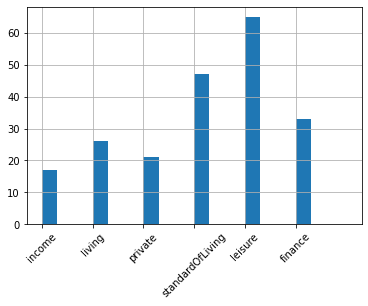

In [265]:
# Visualize label counts.
from matplotlib.pyplot import show

transaction_df["label"].hist(bins=range(7), xrot=45, width=0.3)
show()

## Step 2 - Analyzing the data

## Step 3 - Cleaning the data

In [266]:
#import math

# Condense Buchungstag date to day only as month and year seldomly change.
#transaction_df["Buchungstag"] = transaction_df["Buchungstag"].apply(lambda x: x[0:2])

# Convert Betrag values to float and standardize them.
transaction_df["Betrag"] = transaction_df["Betrag"].apply(lambda x: float(x.replace(',', '.')))
transaction_df["Betrag"] = (transaction_df["Betrag"] - transaction_df["Betrag"].mean())/ transaction_df["Betrag"].std()

# Alternative with rounding to next 10. Do not use as it yields worse results.
#transaction_df['Betrag'] = transaction_df['Betrag'].apply(lambda x: math.ceil(float(x.replace(',', '.'))/10.0)*10)

# For each column except labels: convert to string, remove case and punctuation/special characters.
#for col in transaction_df.columns[:-1]:
 #   transaction_df[col] = transaction_df[col].fillna("keine Angabe")
  #  transaction_df[col] = transaction_df[col].apply(str).str.replace('\W', ' ').str.lower()

#transaction_df.head(20)

In [267]:
# Generate count on individual words in Verwendungszweck. Also removes case, punctuation and special characters. 
from sklearn.feature_extraction.text import CountVectorizer

cvec = CountVectorizer()
cvec.fit(transaction_df["Verwendungszweck"])
counts = cvec.transform(transaction_df["Verwendungszweck"]).toarray()

verwendungszweck_df = pd.DataFrame(counts, columns=cvec.get_feature_names())

## Step 4 - Formatting the data

In [268]:
# Omit Valutadatum and Waehrung.
feature_count = pd.concat([pd.get_dummies(transaction_df["Auftragskonto"]),
                           pd.get_dummies(transaction_df["Buchungstag"]),
                           pd.get_dummies(transaction_df["Buchungstext"]),
                           verwendungszweck_df,
                           pd.get_dummies(transaction_df["Beguenstigter/Zahlungspflichtiger"]),
                           pd.get_dummies(transaction_df["Kontonummer"]),
                           pd.get_dummies(transaction_df["BLZ"]),
                           pd.get_dummies(transaction_df["Betrag"])], axis=1)

In [269]:
# Split training and test data.
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(feature_count, transaction_df['label'], test_size=0.25, random_state=1)

## Step 5 - Training and applying the model

In [277]:
# Train model on training data.
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(trainX, trainY)

In [ ]:
# Generate prediction on test data.
test_result = model.predict(testX)

## Step 6 - Evaluating the model's predictions

In [284]:
# Generate various metrics.
from sklearn import metrics
from sklearn.model_selection import cross_val_score, ShuffleSplit

print("\033[1mAccuracy\033[0m      : {}".format(metrics.accuracy_score(testY, test_result)))
print("\033[1mPrecision\033[0m     : {}".format(metrics.precision_score(testY, test_result, average='weighted')))
print("\033[1mRecall\033[0m        : {}".format(metrics.recall_score(testY, test_result, average='weighted')))
print("\033[1mF1\033[0m            : {}".format(metrics.f1_score(testY, test_result, average='weighted')))
print("\033[1mHamming Loss\033[0m  : {}".format(metrics.hamming_loss(testY,test_result)))

# Cross validation with random permutation.
crossval = ShuffleSplit(n_splits=10, test_size=0.2, random_state=1337)
scores = cross_val_score(model, testX, testY, cv=crossval)
print("\033[1mCrossVal mean\033[0m : {}".format(scores.mean()))

Accuracy      : 0.9433962264150944
Precision     : 0.9465408805031448
Recall        : 0.9433962264150944
F1            : 0.9439044533384157
Hamming Loss  : 0.05660377358490566
CrossVal mean : 0.8363636363636363


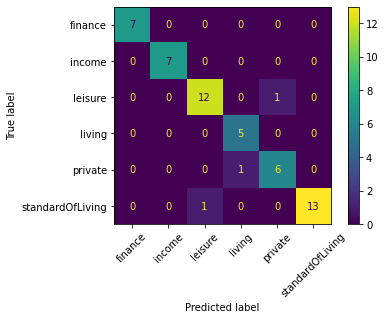

In [281]:
# Visualize result with confusion matrix.
metrics.plot_confusion_matrix(model, testX, testY, xticks_rotation=45)
show()